In [1]:
import sys
sys.path.append('../src')

In [2]:
import pandas as pd
import numpy as np
from utils import quick_eda, rolling_average

df_train = pd.read_csv('../data/playground-series-s5e3/train.csv')
quick_eda(df_train)

Shape: 2190 rows and 13 columns
Duplicates check: 0 duplicate rows found

Sample data:


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


Data types and missing count:


,dtype,non_missing,missing,missing_pct
id,int64,2190,0,0.0
day,int64,2190,0,0.0
pressure,float64,2190,0,0.0
maxtemp,float64,2190,0,0.0
temparature,float64,2190,0,0.0
mintemp,float64,2190,0,0.0
dewpoint,float64,2190,0,0.0
humidity,float64,2190,0,0.0
cloud,float64,2190,0,0.0
sunshine,float64,2190,0,0.0


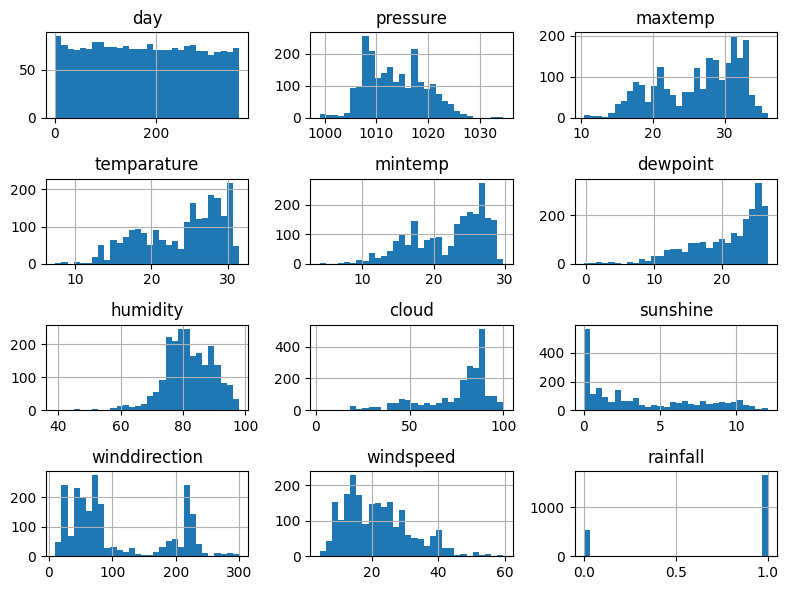

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df_train.drop(columns='id').hist(figsize=(8, 6), bins=30)
plt.tight_layout()
plt.show()

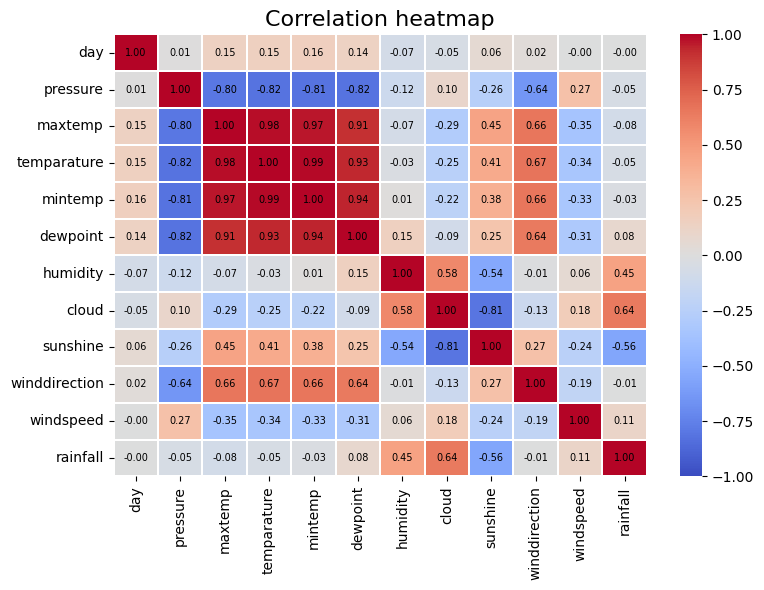

In [4]:
corr_matrix = df_train.drop(columns='id').corr()

plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.01,
    annot=True,
    annot_kws={'fontsize':7, 'color': 'black'},
    fmt='.2f'
)

plt.title('Correlation heatmap', fontsize=16)
plt.tight_layout()
plt.show()

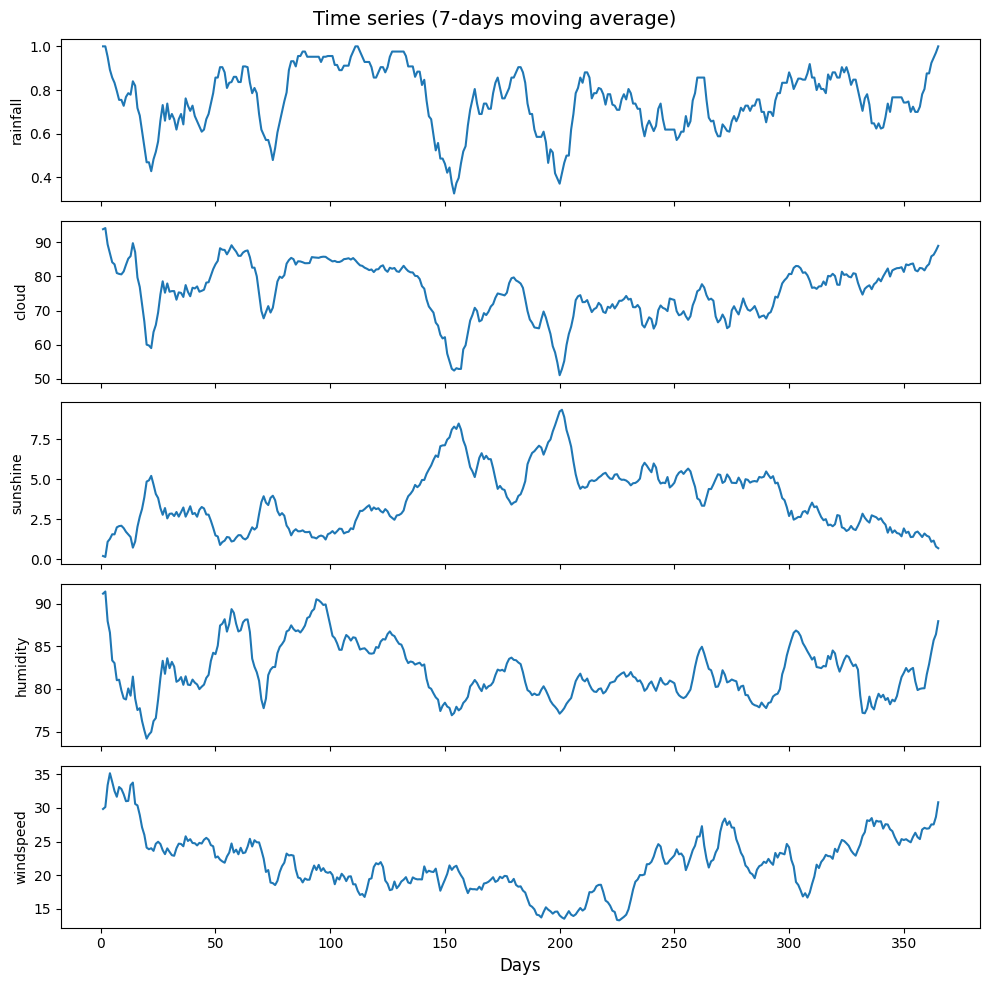

In [5]:
outcomes = ['rainfall', 'cloud', 'sunshine', 'humidity', 'windspeed']
time_series = rolling_average(df_train, 'day', outcomes, window=7)

fig, axes = plt.subplots(
    nrows=len(outcomes), 
    ncols=1, 
    figsize=(10, 10), 
    sharex=True
)

for i, var in enumerate(outcomes):
    subset = time_series[time_series['variables'] == var]
    
    axes[i].plot(subset['day'], subset['values'], linewidth=1.5)
    axes[i].set_ylabel(var, fontsize=10)

plt.suptitle('Time series (7-days moving average)', fontsize=14)
plt.xlabel('Days', fontsize=12)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

x = df_train.drop(columns=['id', 'rainfall'])
y = df_train['rainfall']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

print(f'Treino: {x_train.shape}')
print(f'Validação: {x_valid.shape}')

Treino: (1752, 11)
Validação: (438, 11)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

features = [col for col in df_train.columns if not col in ['id', 'rainfall']]

preprocessor = ColumnTransformer(transformers=[('scaler', StandardScaler(), features)])

logit_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

logit_pipeline.fit(x_train, y_train)

y_pred = logit_pipeline.predict_proba(x_valid)[:, 1]
score = roc_auc_score(y_valid, y_pred)

print(f'AUC (validação): {score:.4f}')

AUC (validação): 0.8724


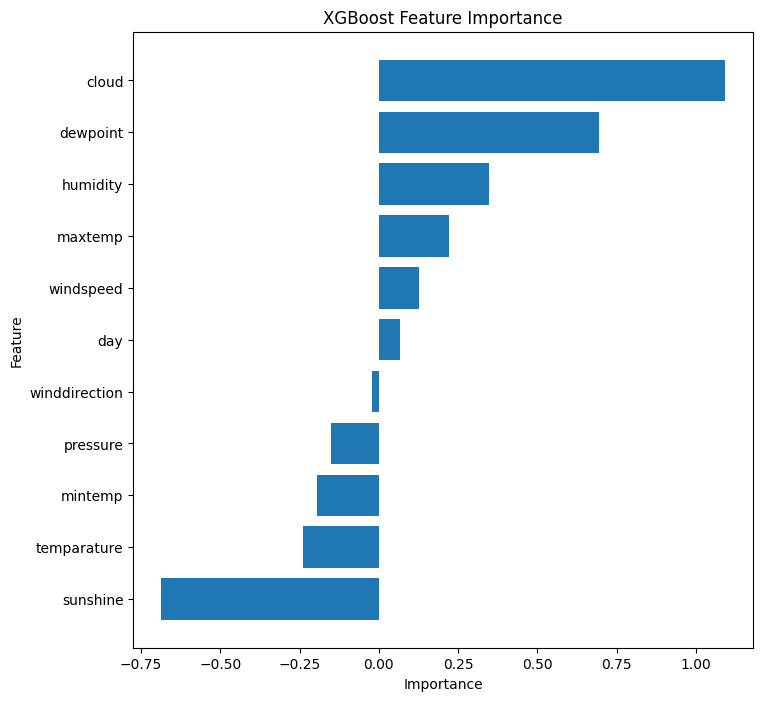

In [8]:
feature_importance = logit_pipeline.named_steps['classifier'].coef_.flatten()
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

features = [col for col in df_train.columns if not col in ['id', 'rainfall']]

preprocessor = ColumnTransformer(transformers=[('scaler', StandardScaler(), features)])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='auc', early_stopping_rounds=100))
])

xgb_paramgrid = {
    'classifier__max_depth': randint(3, 6),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__n_estimators': randint(100, 500),
    'classifier__subsample': uniform(0.5, 0.5),
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__gamma': uniform(0, 0.3),
    'classifier__reg_alpha': uniform(0, 0.5),
    'classifier__reg_lambda': randint(1, 6)
}

xgb_gridsearch = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_paramgrid,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

preprocessor.fit(x_train)
x_valid_transformed = preprocessor.transform(x_valid)

xgb_gridsearch.fit(
    x_train, y_train,
    classifier__eval_set=[(x_valid_transformed, y_valid)],
    classifier__verbose=20
)

print('Melhores parâmetros:', xgb_gridsearch.best_params_)

y_pred = xgb_gridsearch.predict_proba(x_valid)[:, 1]
score = roc_auc_score(y_valid, y_pred)

print(f'AUC (validação): {score:.4f}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-auc:0.83147
[20]	validation_0-auc:0.86402
[40]	validation_0-auc:0.86285
[60]	validation_0-auc:0.86597
[80]	validation_0-auc:0.86564
[100]	validation_0-auc:0.86671
[120]	validation_0-auc:0.86831
[140]	validation_0-auc:0.86944
[160]	validation_0-auc:0.86968
[180]	validation_0-auc:0.87121
[200]	validation_0-auc:0.87168
[220]	validation_0-auc:0.87250
[240]	validation_0-auc:0.87211
[260]	validation_0-auc:0.87089
[280]	validation_0-auc:0.87071
[300]	validation_0-auc:0.87066
[320]	validation_0-auc:0.87139
[332]	validation_0-auc:0.87124
Melhores parâmetros: {'classifier__colsample_bytree': np.float64(0.6432706260641422), 'classifier__gamma': np.float64(0.17724997817070323), 'classifier__learning_rate': np.float64(0.016100049987809888), 'classifier__max_depth': 4, 'classifier__n_estimators': 425, 'classifier__reg_alpha': np.float64(0.1516327573366114), 'classifier__reg_lambda': 3, 'classifier__subsample': np.float64(

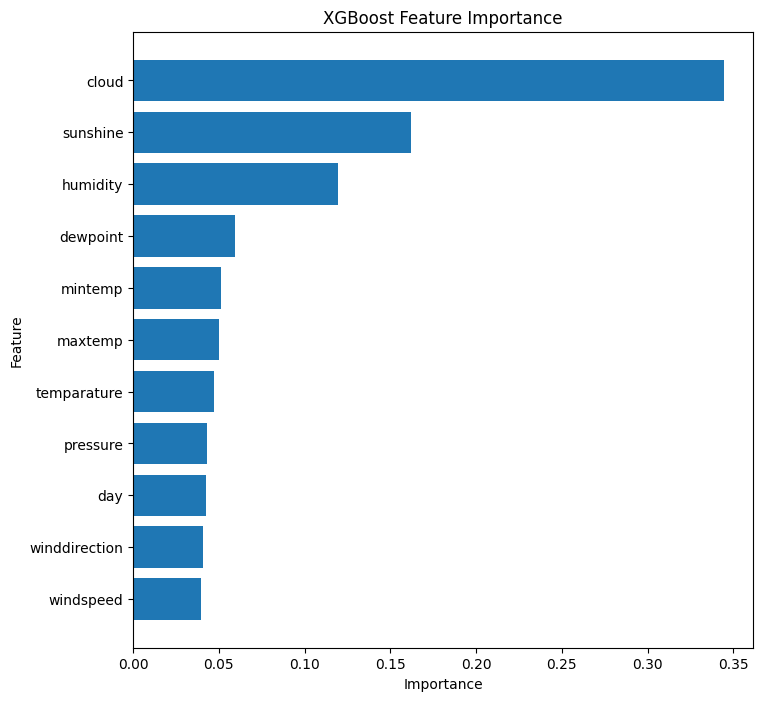

In [11]:
feature_importance = xgb_gridsearch.best_estimator_.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

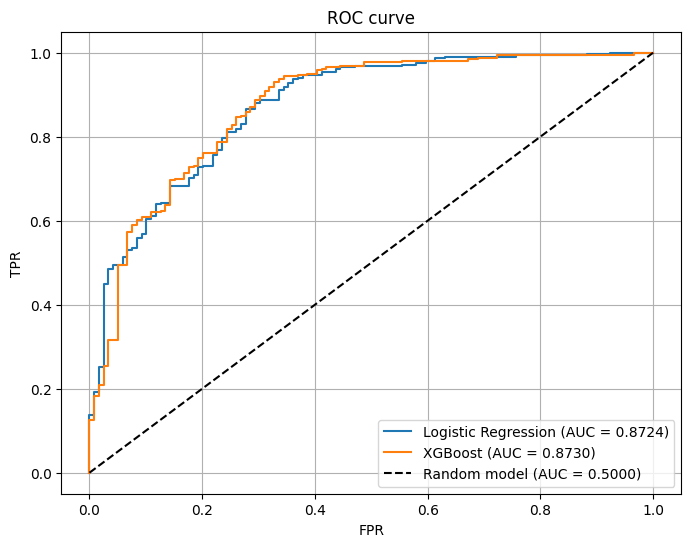

In [14]:
from sklearn.metrics import roc_curve, auc

y_pred_logit = logit_pipeline.predict_proba(x_valid)[:, 1]
y_pred_xgb = xgb_gridsearch.predict_proba(x_valid)[:, 1]

fpr_logit, tpr_logit, _ = roc_curve(y_valid, y_pred_logit)
roc_auc_logit = auc(fpr_logit, tpr_logit)

fpr_xgb, tpr_xgb, _ = roc_curve(y_valid, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logit, tpr_logit, label=f'Logistic Regression (AUC = {roc_auc_logit:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random model (AUC = 0.5000)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()

In [15]:
df_test = pd.read_csv('../data/playground-series-s5e3/test.csv')
quick_eda(df_test)

Shape: 730 rows and 12 columns
Duplicates check: 0 duplicate rows found

Sample data:


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


Data types and missing count:


,dtype,non_missing,missing,missing_pct
id,int64,730,0,0.00
day,int64,730,0,0.00
pressure,float64,730,0,0.00
maxtemp,float64,730,0,0.00
temparature,float64,730,0,0.00
mintemp,float64,730,0,0.00
dewpoint,float64,730,0,0.00
humidity,float64,730,0,0.00
cloud,float64,730,0,0.00
sunshine,float64,730,0,0.00


In [16]:
df_test.fillna(df_train.median(), inplace=True)

test_prob = xgb_gridsearch.predict_proba(df_test)[:, 1]

submission = pd.read_csv('../data/playground-series-s5e3/sample_submission.csv')
submission['rainfall'] = test_prob
submission.to_csv('../outputs/playground-series-s5e3/submission.csv', index=False)
submission.head()

,id,rainfall
0,2190,0.973967
1,2191,0.972827
2,2192,0.905955
3,2193,0.180804
4,2194,0.105950
